# **3D analysis**

This tutorial does a 3D map based analsis on the galactic center, using simulated observations from the CTA-1DC. We will use `gammapy.data.DataStore` to get the data, do the data reduction, and then do a detailed modelling. This will be done in two different ways:

- stacking all the maps together and fitting the stacked maps
- handling all the observations separately and doing a joint fitting on all the maps

This exemple is based on the following tutorials:
- https://docs.gammapy.org/0.18.2/tutorials/cta_data_analysis.html
- https://docs.gammapy.org/0.18.2/tutorials/analysis_3d.html

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from pathlib import Path
from regions import CircleSkyRegion
from gammapy.utils.regions import make_region
from scipy.stats import norm,chi2
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
)
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom
from gammapy.estimators import ExcessMapEstimator
from gammapy.datasets import MapDataset

In [2]:
# Configure the logger, so that the 3D analysis isn't so chatty about what it's doing.
import logging

logging.basicConfig()
log = logging.getLogger("gammapy.modeling")
log.setLevel(logging.INFO)
# See https://docs.python.org/3/library/logging.html#levels to get the different level of print-out
#log.setLevel(logging.ERROR)

## Analysis configuration

In this section we select observations `gammapy.data.DataStore` and define the analysis geometries, irrespective of  joint/stacked analysis. For configuration of the analysis, we will programatically build a config file from scratch.

### **Select observations**

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

In [4]:
# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

In [5]:
obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME"]
data_store.obs_table[obs_cols]

OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME
,deg,deg,s
int64,float64,float64,float64
110380,359.9999912037958,-1.299995937905366,1764.0
111140,358.4999833830074,1.3000020211954284,1764.0
111159,1.5000056568267741,1.299940468335294,1764.0
111630,263.9999985700299,-1.299980552289047,1764.0


In [6]:
# Let's select only 3 observations
obs_id = [110380, 111140, 111159]
observations = data_store.get_observations(obs_id)
# Otherwise just do:
# observations = data_store.get_observations()

### **Define map geometry**

Select the target position and define an ON region for the spectral analysis

In [44]:
# We now fix the energy axis for the counts map - (the reconstructed energy binning)
e_reco = MapAxis.from_energy_bounds(0.1, 10, 10, unit="TeV", name="energy")

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true energy binning)
e_true = MapAxis.from_energy_bounds(0.08, 12, 24, unit="TeV", name="energy_true")

# The WCS geometry - centered on the galactic center
geom = WcsGeom.create(skydir=(0, 0), npix=(500, 400), binsz=0.02, frame="galactic", axes=[e_reco])
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 400, 10)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 8.0 deg



## **Stacked analysis**

### **Configuration of the `MapDataset` and of the data reduction makers**

In [55]:
dataset_empty = MapDataset.create(geom=geom, energy_axis_true=e_true)

dataset_maker = MapDatasetMaker(selection=["counts", "background", "exposure", "psf", "edisp"])
# equivalent to maker = MapDatasetMaker()

safe_mask_masker = SafeMaskMaker(methods=["offset-max", "aeff-default"], offset_max=2.0 * u.deg)
# See the documentation of `~gammapy.makers.SafeMaskMaker` to get the full list of options
# Atreyee: to be described during the school??

### **Make the Data Reduction** ###
<a id='DataReduction'></a>

In [56]:
%%time
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=f"obs-{observation.obs_id}"), observation)
    dataset = safe_mask_masker.run(dataset, observation)
    datasets.append(dataset)

/home/khelifi/MesProgrammes/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/MesProgrammes/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/MesProgrammes/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/MesProgrammes/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/

CPU times: user 22.9 s, sys: 7.85 s, total: 30.8 s
Wall time: 30.8 s


In [57]:
# We have one final dataset, which you can print
dataset_stacked = datasets.stack_reduce(name="stacked")
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 62858 
  Total background counts         : 54776.27
  Total excess counts             : 8081.73

  Predicted counts                : 54776.27
  Predicted background counts     : 54776.27
  Predicted excess counts         : nan

  Exposure min                    : 1.19e+08 m2 s
  Exposure max                    : 1.93e+10 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 815400 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### **Exploration of the stacked dataset**

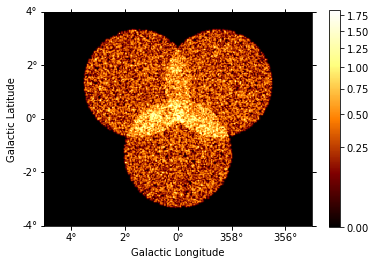

In [58]:
# To plot a smooth counts map
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)

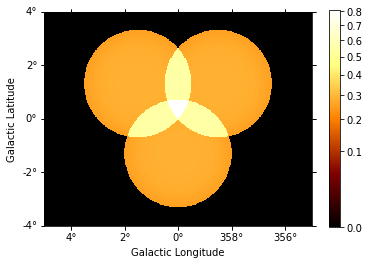

In [59]:
# And the background map
dataset_stacked.background.plot_interactive(add_cbar=True)

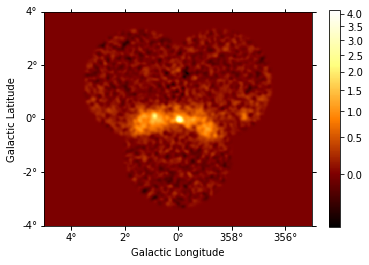

In [60]:
# You can also get an excess image with a few lines of code:
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);

### **Modeling and fitting**

Now comes the interesting part of the analysis - choosing appropriate models for our source and fitting them.
We choose a point source model with an exponential cutoff power-law spectrum.

To select a certain energy range for the fit we can create a fit mask:

In [61]:
coords = dataset_stacked.counts.geom.get_coord()
mask_energy = coords["energy"] > 0.3 * u.TeV
dataset_stacked.mask_fit = Map.from_geom(geom=dataset_stacked.counts.geom, data=mask_energy)

We define the model of background, stored into the IRFs

In [63]:
bkg_model = FoVBackgroundModel(dataset_name="stacked")
bkg_model.spectral_model.norm.value = 1.3

We choose a point source model with an exponential cutoff power-law spectrum.

In [64]:
spatial_model = PointSpatialModel(lon_0="-0.05 deg", lat_0="-0.05 deg", frame="galactic")
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

# If you want to constrain some parameters, see e.g.
model.spectral_model.parameters['amplitude'].min = 1.e-16

**Set only the background model and get the log(Likelihood) of the fit**

In [65]:
models_stacked = Models([bkg_model])
dataset_stacked.models = models_stacked

In [66]:
%%time
fit = Fit([dataset_stacked])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 1.542E+05               |      Ncalls=18 (18 total)      |
| EDM = 4.42E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 479 ms, sys: 3.78 ms, total: 483 ms
Wall time: 481 ms


Fit quality assesment and model residuals for a `MapDataset`
We can access the results dictionary to see if the fit converged:

In [67]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 18
	total stat : 154243.06



Check best-fit parameters and error estimates:

In [68]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str3,float64,float64,bool,float64
norm,1.3332e+00,,nan,nan,False,9.498e-03
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [69]:
# Get the fit statistics: - 2 * log(L)
H0 = dataset_stacked.stat_sum()
print(H0)
dof_H0 = len(dataset_stacked.models.parameters.free_parameters)
print(f"Degrees of fredoom of the Hypothesis #0: {dof_H0}")

154243.05837539528
Degrees of fredoom of the Hypothesis #0: 1


**Add a source model**

In [70]:
models_stacked = Models([model, bkg_model])

dataset_stacked.models = models_stacked

In [71]:
%%time
fit = Fit([dataset_stacked])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 1.533E+05               |     Ncalls=261 (261 total)     |
| EDM = 3.94E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 12.4 s, sys: 18.4 ms, total: 12.4 s
Wall time: 12.4 s


In [72]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 261
	total stat : 153304.16



In [73]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.3695e+00,,nan,nan,False,1.499e-01
amplitude,2.5649e-12,cm-2 s-1 TeV-1,1.000e-16,nan,False,3.829e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lambda_,-2.3914e-02,TeV-1,nan,nan,False,7.794e-02
alpha,1.0000e+00,,nan,nan,True,0.000e+00
lon_0,-5.2785e-02,deg,nan,nan,False,2.857e-03
lat_0,-4.8659e-02,deg,-9.000e+01,9.000e+01,False,2.861e-03
norm,1.3162e+00,,nan,nan,False,9.450e-03
tilt,0.0000e+00,,nan,nan,True,0.000e+00


In [74]:
H1 = dataset_stacked.stat_sum()
print(H1)
dof_H1 = len(dataset_stacked.models.parameters.free_parameters)
print(f"Degrees of fredoom of the Hypothesis #1: {dof_H1}")

153304.15806605466
Degrees of fredoom of the Hypothesis #1: 6


**Determination of the significance of H1 over H0**

See [here](https://docs.gammapy.org/0.18.2/stats/index.html?highlight=degrees%20freedom#estimating-ts) the statistical details.

In [75]:
TS = H0 - H1
dof = dof_H1 -dof_H0
print(f"Delta(TS) = {TS}")
#Convert delta ts to sigma
p_value = chi2.sf(TS, df=dof)
sigma = norm.isf(0.5 * p_value)
print(f"Significance of H1 over H0: {sigma:.2f}")

Delta(TS) = 938.9003093406209
Significance of H1 over H0: 30.23


### **Visual inspection of the results**
A quick way to inspect the model residuals is using the function `~MapDataset.plot_residuals_spatial()`. This function computes and plots a residual image (by default, the smoothing radius is `0.1 deg` and `method=diff`, which corresponds to a simple `data - model` plot):

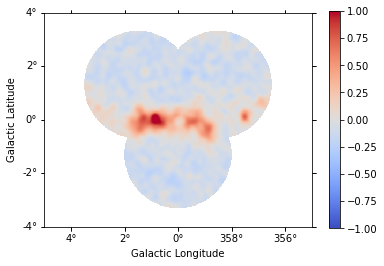

In [76]:
dataset_stacked.plot_residuals_spatial(
    method="diff/sqrt(model)", vmin=-1, vmax=1
);

The more general function `~MapDataset.plot_residuals()` can also extract and display spectral residuals in a region:

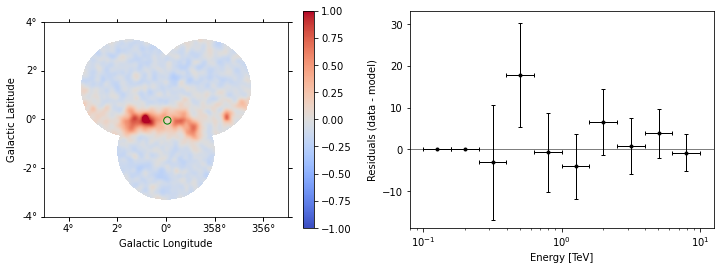

In [77]:
region = CircleSkyRegion(spatial_model.position, radius=0.15 * u.deg)

dataset_stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
);

This way of accessing residuals is quick and handy, but comes with limitations. For example:
- In case a fitting energy range was defined using a `MapDataset.mask_fit`, it won't be taken into account. Residuals will be summed up over the whole reconstructed energy range
- In order to make a proper statistic treatment, instead of simple residuals a proper residuals significance map should be computed

A more accurate way to inspect spatial residuals is the following:

/home/khelifi/MesProgrammes/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


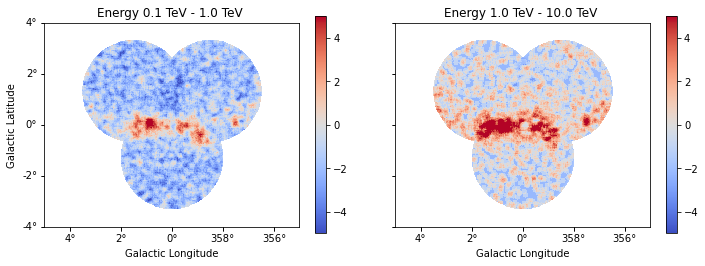

In [78]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.1, 1, 10] * u.TeV,
)

result = estimator.run(dataset_stacked)

result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
);

Distribution of residuals significance in the full map geometry:

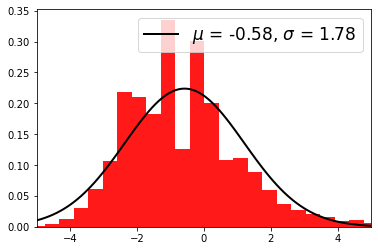

In [79]:
significance_data = result["sqrt_ts"].data

#Remove bins that are inside an exclusion region, that would create an artificial peak at significance=0.
selection = np.isfinite(significance_data) & ~(significance_data == 0)
significance_data = significance_data[selection]

plt.hist(significance_data, density=True, alpha=0.9, color="red", bins=40)
mu, std = norm.fit(significance_data)

x = np.linspace(-5, 5, 100)
p = norm.pdf(x, mu, std)

plt.plot(
    x,
    p,
    lw=2,
    color="black",
    label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, std),
);
plt.legend(fontsize=17);
plt.xlim(-5, 5);

## **Joint analysis**

In this section, we perform a joint analysis of the same data. Of course, joint fitting is considerably heavier than stacked one, and should always be handled with care. For brevity, we only show the analysis for a point source fitting without re-adding a diffuse component again. 

### **The joint dataset**
The joint dataset has been already computed during the [DataReduction](#DataReduction). It is called `datasets`.


In [80]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : obs-110380
  Instrument : CTA
  Models     : 

Dataset 1: 

  Type       : MapDataset
  Name       : obs-111140
  Instrument : CTA
  Models     : 

Dataset 2: 

  Type       : MapDataset
  Name       : obs-111159
  Instrument : CTA
  Models     : 




In [81]:
# You can access to the details of each one by name or by index, eg:
print(datasets[0])
print(datasets['obs-111140'])

MapDataset
----------

  Name                            : obs-110380 

  Total counts                    : 21431 
  Total background counts         : 18258.57
  Total excess counts             : 3172.43

  Predicted counts                : 18258.57
  Predicted background counts     : 18258.57
  Predicted excess counts         : nan

  Exposure min                    : 1.19e+08 m2 s
  Exposure max                    : 6.78e+09 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 314350 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


MapDataset
----------

  Name                            : obs-111140 

  Total counts                    : 20833 
  Total background counts         : 18258.57
  Total excess counts             : 2574.43

  Predicted counts                : 18258.57
  Predicted background c

After the data reduction stage, it is nice to get a quick summary info on the datasets. 
Here, we look at the statistics in the center of Map, by passing an appropriate `region`. To get info on the entire spatial map, omit the region argument.

In [82]:
datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str10,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
obs-110380,21431.0,18258.573981980247,3172.4260180197525,22.842211741021867,18258.573981980247,18258.573981980247,nan,119380165.65390997,6782120076.967049,nan,1800.0,nan,nan,nan,2000000,314350,cash,nan
obs-111140,20833.0,18258.57329500114,2574.4267049988593,18.62905225245817,18258.57329500114,18258.57329500114,nan,119380458.03862461,6782120662.9253025,nan,1800.0,nan,nan,nan,2000000,314350,cash,nan
obs-111159,20594.0,18259.12319446573,2334.87680553427,16.930139149393526,18259.12319446573,18259.12319446573,nan,119380515.51865318,6782125346.940769,nan,1800.0,nan,nan,nan,2000000,314360,cash,nan


### **Definition of the model of the data to fit**

In [83]:
models_joint = Models()

model_joint = model.copy(name="source-joint")
models_joint.append(model_joint)

for dataset in datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.spectral_model.norm.value = 1.3
    models_joint.append(bkg_model)

print(models_joint)

Models

Component 0: SkyModel

  Name                      : source-joint
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.369              
    amplitude               :   2.56e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :  -0.024  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   :  -0.053  deg         
    lat_0                   :  -0.049  deg         

Component 1: FoVBackgroundModel

  Name                      : obs-110380-bkg
  Datasets names            : ['obs-110380']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.300              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoV

In [84]:
# and set the new model
datasets.models = models_joint

### **Make the fit**

In [85]:
%%time
fit_joint = Fit(datasets)
result_joint = fit_joint.run()

CPU times: user 21.9 s, sys: 18.5 ms, total: 21.9 s
Wall time: 21.9 s


### Fit quality assessment and model residuals for a joint `Datasets` 

We can access the results dictionary to see if the fit converged:

In [86]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 224
	total stat : 373800.47



Check best-fit parameters and error estimates:

In [87]:
print(models_joint)

Models

Component 0: SkyModel

  Name                      : source-joint
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.332              
    amplitude               :   2.64e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :  -0.008  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   :  -0.053  deg         
    lat_0                   :  -0.049  deg         

Component 1: FoVBackgroundModel

  Name                      : obs-110380-bkg
  Datasets names            : ['obs-110380']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.161              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 2: FoV

Since the joint dataset is made of multiple datasets, we can either:
- Look at the residuals for each dataset separately. In this case, we can directly refer to the section `Fit quality and model residuals for a MapDataset` in this notebook
- Look at a stacked residual map. 

In the latter case, we need to properly stack the joint dataset before computing the residuals:

In [40]:
# We need to stack on the full geometry, so we use to geom from the stacked counts map.
stacked_after_fit = MapDataset.from_geoms(**dataset_stacked.geoms)

for dataset in datasets:
    # TODO: Apply mask_fit before stacking
    stacked_after_fit.stack(dataset)

stacked_after_fit.models = [model_joint]

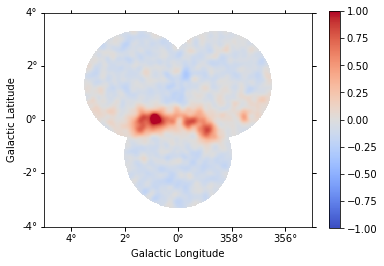

In [41]:
stacked_after_fit.plot_residuals_spatial(vmin=-1, vmax=1);

Then, we can access the stacked model residuals as previously shown in the section `Fit quality and model residuals for a MapDataset` in this notebook.

Finally, let us compare the spectral results from the stacked and joint fit:

In [42]:
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.3, 10] * u.TeV....
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)

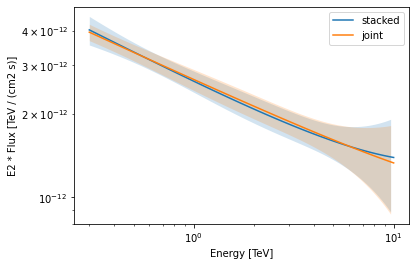

In [43]:
plot_spectrum(model, result, label="stacked", color="tab:blue")
plot_spectrum(model_joint, result_joint, label="joint", color="tab:orange")
plt.legend()

## **Summary**

1. The background model should be adapted to the data. This tutorial shows two methods to do it: the stacked method with a final adjustment, the joint method with a observation-wise adjustement. The recommanded method is the following, as exemplified in the [2D analysis tutotial](https://docs.gammapy.org/0.18.2/tutorials/analysis_2.html):
- define an exclusion region on which the background level should not be ajusted (see the [exclusion mask tutorial](https://docs.gammapy.org/0.18.2/tutorials/exclusion_mask.html))
- during the Data Reduction step, use the [~gammapy.makers.FoVBackgroundMaker](https://docs.gammapy.org/0.18.2/api/gammapy.makers.FoVBackgroundMaker.html) to adjust the background level to each observation, and then stack the observation-wise datasets
- during the step of model/fit, let free the stacked background model for the fit

2. Note that this notebook aims to show you the procedure of a 3D analysis using just a few observations. Results get much better for a more complete analysis considering the GPS dataset from the CTA First Data Challenge (DC-1) and also the CTA model for the Galactic diffuse emission, as shown in the next image:

![](./images/DC1_3d.png)

The complete tutorial notebook of this analysis is available to be downloaded in [GAMMAPY-EXTRA](https://github.com/gammapy/gammapy-extra) repository at https://github.com/gammapy/gammapy-extra/blob/master/analyses/cta_1dc_gc_3d.ipynb). It uses the High Level Interface of gammapy to make the Data Reduction.

## **Exercises**

* Perform the analysis as described in the summary section
* Analyse the second source in the field of view: G0.9+0.1 and add it to the combined model.
* Perform modeling in more details - Add diffuse component, get flux points.